## Prepare ERA5-Land total precipitation

In this notebook, monthly aggregated ERA5-Land precipitation data from 1981 - 2025 is processed. 
The following steps are included:
- Convert aggregated precipitation from "m of water equivalent per day" to "mm / month"
- Crop data to Germany

In [1]:
# import libraries
import os
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import odc.stac
import rasterio
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# open dataset
# the data has ben split into two while downloading
filelist = ("./Raw/ERA5-Land/data_2.nc", "./Raw/ERA5-Land/data_3.nc")
era5 = xr.open_mfdataset(filelist, concat_dim="valid_time", combine='nested')

In [5]:
era5

<xarray.Dataset> Size: 17MB
Dimensions:     (valid_time: 528, latitude: 83, longitude: 98)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1981-01-01 ... 2024-02-01
  * latitude    (latitude) float64 664B 55.2 55.1 55.0 54.9 ... 47.2 47.1 47.0
  * longitude   (longitude) float64 784B 5.45 5.55 5.65 ... 14.95 15.05 15.15
    expver      (valid_time) <U4 8kB dask.array<chunksize=(262,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 17MB dask.array<chunksize=(262, 83, 98), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
# rename dimensions to fit other data
era5 = era5.rename({"valid_time":"time",
                            "longitude": "lon",
                            "latitude": "lat"})

In [7]:
# sort by date
era5 = era5.sortby("time")

In [8]:
# extract precipitation data
tp = era5.drop_vars(["number", "expver"])
tp

<xarray.Dataset> Size: 17MB
Dimensions:  (time: 528, lat: 83, lon: 98)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
  * lat      (lat) float64 664B 55.2 55.1 55.0 54.9 54.8 ... 47.3 47.2 47.1 47.0
  * lon      (lon) float64 784B 5.45 5.55 5.65 5.75 ... 14.85 14.95 15.05 15.15
Data variables:
    tp       (time, lat, lon) float32 17MB dask.array<chunksize=(264, 83, 98), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [9]:
# look at variable attributes
tp.tp.attrs

{'GRIB_paramId': np.int64(228),
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': np.int64(8134),
 'GRIB_typeOfLevel': 'surface',
 'GRIB_stepUnits': np.int64(1),
 'GRIB_stepType': 'avgas',
 'GRIB_gridType': 'regular_ll',
 'GRIB_uvRelativeToGrid': np.int64(0),
 'GRIB_NV': np.int64(0),
 'GRIB_Nx': np.int64(98),
 'GRIB_Ny': np.int64(83),
 'GRIB_cfName': 'unknown',
 'GRIB_cfVarName': 'tp',
 'GRIB_gridDefinitionDescription': 'Latitude/Longitude Grid',
 'GRIB_iDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_iScansNegatively': np.int64(0),
 'GRIB_jDirectionIncrementInDegrees': np.float64(0.1),
 'GRIB_jPointsAreConsecutive': np.int64(0),
 'GRIB_jScansPositively': np.int64(0),
 'GRIB_latitudeOfFirstGridPointInDegrees': np.float64(55.2),
 'GRIB_latitudeOfLastGridPointInDegrees': np.float64(47.0),
 'GRIB_longitudeOfFirstGridPointInDegrees': np.float64(5.45),
 'GRIB_longitudeOfLastGridPointInDegrees': np.float64(15.15),
 'GRIB_missingValue': np.float64(3.4028234663852886e+38),
 'GRIB_name': 'T

In [10]:
# convert precipitation from "m of water equivalent per day" to "mm / month"
# source: ECMWF conversion table https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790
tp['tp'] = tp.tp * 1000 * tp.tp.time.dt.days_in_month

In [11]:
# change unit in variable attributes
tp.tp.attrs["units"] = "mm/month"

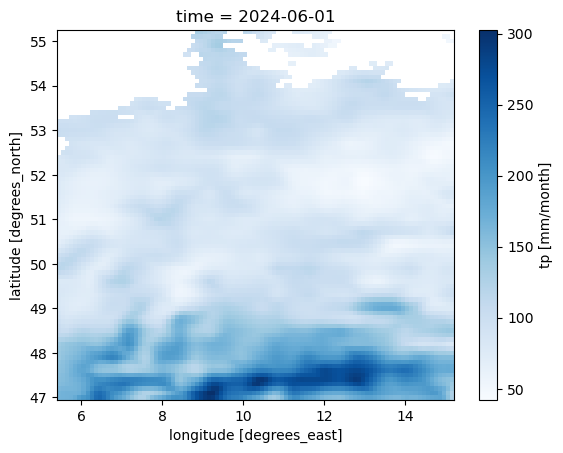

In [12]:
# plot exemplary data of one month to get a first impression
tp.tp.sel(time='2024-06-01').plot(cmap='Blues')

In [13]:
# check crs
tp.rio.crs

In [14]:
# assign crs to data
tp = tp.rio.write_crs('WGS 1984')

In [15]:
# load Germany shapefile 
ger = gpd.read_file("./GER.shp")

In [16]:
# check if crs matches data
ger.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# extract one date to create mask of germany with dimensions of climate data
tp_ex = tp.sel(time = "1981-08-01", method = "nearest")

In [18]:
# create mask of research area using the dimensions of the exemplary climate data
ger_mask = rasterio.features.geometry_mask(ger.geometry, 
                                            out_shape=tp_ex.odc.geobox.shape,
                                            transform=tp_ex.odc.geobox.affine,
                                            all_touched=False,
                                            invert=False)

In [19]:
ger_mask = xr.DataArray(ger_mask, dims=("lat", "lon"))

In [20]:
# create loop to process precipitation data per year
for year in range(1981, 2025):
    
    # select all monthly data within this year
    tp_yearly = tp.sel(time = tp.time.dt.year.isin(year))

    # apply mask of research area to dataset
    tp_ger = tp_yearly["tp"].where(~ger_mask)

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    tp_ger.encoding.update(comp)

    # save as netCDF4 dataset
    tp_ger.to_netcdf(f"./Climate/Precipitation/Monthly/tp_mon_sum_{year}_GER.nc")


In [21]:
# load one processed dataset as example and plot to get an overview
tp = xr.open_dataarray("./Climate/Precipitation/Monthly/tp_mon_sum_2024_GER.nc", decode_coords = "all", decode_times= True)

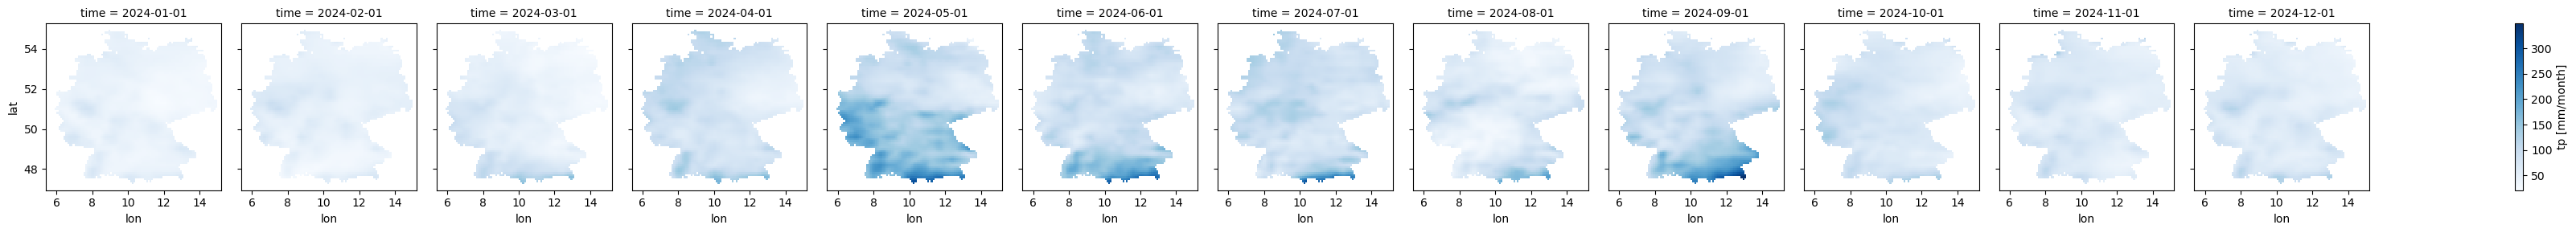

In [22]:
tp.sel(time = slice('2024-01', '2024-12')).plot(col="time", cmap='Blues')